# __セルフレジ__

#### __試行__
- __2019/07/07の現状__
    - Predict速度の向上が必要
        - Mobilenetの1層目から学習
            - →　Predictが相当遅くなる
        - Dense層1層のみを加え、学習する
            - →　Predictの速度が向上し,5/6の正解
        - Dense層を二層加え、Mobilenetの最後の層のみ学習
            - →　14, 15, 16層以降のみ学習させたが、実のデータでの検証失敗
            - → Mobile net層を一切学習せず、自作の層を三層追加したものの検証失敗
        - Mobilenetの途中層から学習をしてみる
            - 10層目からの学習 : ダメ
            - 7 :　ダメ
        - MobileNetは学習せず、Dense層のみ学習
            - 128, 64, 32, 16, 8, 1, 全てDropout0.2
                - だめ
            

#### __試行__
- 2019/07/08現状
    - mobile[16~] + 8 + 1
        - 0.81
    - mobile[15~] + 8 + 1
        - 0.72
    - mobile[14~] + 8 + 1
        - 0.8823529411764706
    - mobile[14~] + 8 + 8 + 1
        - 0.8823529411764706
    - mobile[14~] + 16 + 8 + 1
        - 0.8823529411764706
    - mobile[13~] + 8 + 1
        - 0.7058823529411765
     

#### __試行__
- 2019/07/09の現状
    - acqueri
    - soda
    - cc_lemon
    - fanta

In [31]:
my_path = 'image_folder/images/'

In [32]:
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm


def augmentation(dir_path, initial_letter_of_file='w', augment_num=5):
    
    
    """
    note : 指定ディレクトリ内の,指定頭文字で始まるファイルを指定枚数オーグメントする
    ----------
    dir_path : フォルダパス
    initial_letter : augmentしたいファイル名の頭文字
    aument_num : augmentしたい枚数
    ----------
    """
    
    
    files_name = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    files_name.remove('.DS_Store')
    
    
    datagen = ImageDataGenerator(rotation_range=40,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
    )
    
    
    for i, file in tqdm(enumerate(files_name)):
        img = load_img(dir_path + file)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape) 

        if file[0] == initial_letter_of_file:
            i = 0
            for batch in datagen.flow(x, save_to_dir=dir_path, save_prefix=initial_letter_of_file, save_format="jpg"):
                i += 1
                if i > augment_num:
                    break

        else:
            pass

In [33]:
augmentation(my_path, 'c')
augmentation(my_path, 'f')
augmentation(my_path, 'l')
augmentation(my_path, 'n')
augmentation(my_path, 's')

349it [00:04, 71.11it/s]
760it [00:05, 150.31it/s]
1167it [00:05, 214.99it/s]
1577it [00:05, 281.04it/s]
1980it [00:06, 328.42it/s]


In [34]:
updated_files_name = [f for f in listdir(my_path) if isfile(join(my_path, f))]

import random
random.seed(0)
random.shuffle(updated_files_name)

In [35]:
updated_files_name[:10]

['c_0_7375.jpg',
 'l_0_2417.jpg',
 'f_0_8290.jpg',
 'n_0_5429.jpg',
 's_0_5126.jpg',
 'n_0_286.jpg',
 'c_0_2108.jpg',
 's_0_6376.jpg',
 'n_0_7324.jpg',
 'n_0_8134.jpg']

#### __前処理__
- ラベルデータの保存
- resize
- test_data, val_dataへの分割
- Dog - 1, Cat - 0
- ディレクトリの作成
    - catsvsdogs / images / train / dogs
    - catsvsdogs / images / train / cats
    - catsvsdogs / images / val / dogs
    - catsvsdogs / images / val / cats

#### __保存用ディレクトリの作成__

In [36]:
import os
import shutil

class0_dir_train = 'image_folder/train/class0/'
class0_dir_val = 'image_folder/test/class0/'

class1_dir_train = 'image_folder/train/class1/'
class1_dir_val = 'image_folder/test/class1/'

class2_dir_train = 'image_folder/train/class2/'
class2_dir_val = 'image_folder/test/class2/'

class3_dir_train = 'image_folder/train/class3/'
class3_dir_val = 'image_folder/test/class3/'

class4_dir_train = 'image_folder/train/class4/'
class4_dir_val = 'image_folder/test/class4/'

def make_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
    
make_dir(class0_dir_train)
make_dir(class0_dir_val)

make_dir(class1_dir_train)
make_dir(class1_dir_val)

make_dir(class2_dir_train)
make_dir(class2_dir_val)

make_dir(class3_dir_train)
make_dir(class3_dir_val)

make_dir(class4_dir_train)
make_dir(class4_dir_val)

#### __データのふるい分け、分割__

In [37]:
import cv2
import numpy as np
import sys
import shutil
from tqdm import tqdm


def train_test_split(files_name, class_0='c', class_1='f', class_2='l', class_3='n', class_4='s' ,train_size=0.8):
    
    """
    note : 画像フォルダから、指定クラスを、指定割合でtrain_sprit
    ----------
    class_0 : クラス名（今回はwilkinson）
    class_1 : クラス名（今回はcoffee）
    train_size : 分割したい割合
    ----------
    """
    
    class_0_count = 0
    class_1_count = 0
    class_2_count = 0
    class_3_count = 0
    class_4_count = 0
    
    each_class_size = len(files_name) // 5
    
    train_size = each_class_size * train_size
    test_size = each_class_size - train_size
    
    training_images = []
    training_labels = []
    test_images = []
    test_labels = []
    training_file_name = []
    test_file_name = []
    
    size=224
    
    for i, file in tqdm(enumerate(files_name)):
        
        if files_name[i][0] == class_0:
            class_0_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_0_count <= train_size:
                training_images.append(image)
                training_labels.append(0)
                training_file_name.append(file)
                cv2.imwrite(class0_dir_train + class_0 + str(class_0_count) + '.jpg', image)
            if class_0_count > train_size and class_0_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(0)
                test_file_name.append(file)
                cv2.imwrite(class0_dir_val + class_0 + str(class_0_count) + '_' + '.jpg', image)

                
        if files_name[i][0] == class_1:
            class_1_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_1_count <= train_size:
                training_images.append(image)
                training_labels.append(1)
                training_file_name.append(file)
                cv2.imwrite(class1_dir_train + class_1 + str(class_1_count) + '.jpg', image)
            if class_1_count > train_size and class_1_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(1)
                test_file_name.append(file)
                cv2.imwrite(class1_dir_val + class_1 + str(class_1_count) + '_' + '.jpg', image)
                
                
        if files_name[i][0] == class_2:
            class_2_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_2_count <= train_size:
                training_images.append(image)
                training_labels.append(2)
                training_file_name.append(file)
                cv2.imwrite(class2_dir_train + class_2 + str(class_2_count) + '.jpg', image)
            if class_2_count > train_size and class_2_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(2)
                test_file_name.append(file)
                cv2.imwrite(class2_dir_val + class_2 + str(class_2_count) + '_' + '.jpg', image)
                
                
        if files_name[i][0] == class_3:
            class_3_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_3_count <= train_size:
                training_images.append(image)
                training_labels.append(3)
                training_file_name.append(file)
                cv2.imwrite(class3_dir_train + class_3 + str(class_3_count) + '.jpg', image)
            if class_3_count > train_size and class_3_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(3)
                test_file_name.append(file)
                cv2.imwrite(class3_dir_val + class_3 + str(class_3_count) + '_' + '.jpg', image)
                
                
        if files_name[i][0] == class_4:
            class_4_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_4_count <= train_size:
                training_images.append(image)
                training_labels.append(4)
                training_file_name.append(file)
                cv2.imwrite(class4_dir_train + class_4 + str(class_4_count) + '.jpg', image)
            if class_4_count > train_size and class_4_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(4)
                test_file_name.append(file)
                cv2.imwrite(class4_dir_val + class_4 + str(class_4_count) + '_' + '.jpg', image)
                
    return training_images, training_labels, test_images, test_labels, training_file_name, test_file_name

In [38]:
training_images, training_labels, test_images, test_labels, training_file_name, test_file_name = train_test_split(updated_files_name)

2389it [00:04, 505.14it/s]


In [39]:
training_file_name[20:35]

['f_0_5484.jpg',
 's_0_2835.jpg',
 'f_0_8941.jpg',
 'l_0_9399.jpg',
 'f_0_32.jpg',
 'f_0_831.jpg',
 's_0_18.jpg',
 'n_0_2334.jpg',
 's_0_9510.jpg',
 'l_0_4139.jpg',
 'f_0_4236.jpg',
 's_0_8366.jpg',
 'n_0_4181.jpg',
 'f_0_5987.jpg',
 'c_0_8104.jpg']

In [40]:
training_labels[20:35]

[1, 4, 1, 2, 1, 1, 4, 3, 4, 2, 1, 4, 3, 1, 0]

In [41]:
class_num = 4
columns = class_num + 1

#### __Kerasが対応するファイル型に変換__

In [42]:
np.savez('multi_classifier_training_data.npz', np.array(training_images))
np.savez('multi_classifier_training_labels.npz', np.identity(columns)[training_labels])
np.savez('multi_classifier_test_data.npz', np.array(test_images))
np.savez('multi_classifier_test_labels.npz', np.identity(columns)[test_labels])

In [43]:
import numpy as np

def load_data_training_and_test(datasetname):
    npzfile = np.load(datasetname + "_training_data.npz")
    train = npzfile["arr_0"]
    
    npzfile = np.load(datasetname + "_training_labels.npz")
    train_labels = npzfile["arr_0"]
    
    npzfile = np.load(datasetname + "_test_data.npz")
    test = npzfile["arr_0"]
    
    npzfile = np.load(datasetname + "_test_labels.npz")
    test_labels = npzfile["arr_0"]
    
    return (train, train_labels), (test, test_labels)

for i in range(1, 11):
    random = np.random.randint(0, len(training_images))
    cv2.imshow("image_" + str(i), training_images[random])
    if training_labels[random] == 0:
        print(str(i) + "- Cat")
    else:
        print(str(i) + "- Dog")
        
cv2.destroyAllWindows()

#### __データの前処理__

In [44]:
(X_train, y_train), (X_test, y_test) = load_data_training_and_test("multi_classifier")

y_train = y_train.reshape(y_train.shape[0], columns)
y_test = y_test.reshape(y_test.shape[0], columns)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

In [45]:
X_train.shape

(1905, 224, 224, 3)

In [46]:
len(y_test)

475

In [47]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

#### __学習__
- 自作の層で学習を行なったが、精度が低い

In [48]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

import os

batch_size = 16
epochs = 8

img_rows = X_train[0].shape[0]
img_cols = X_train[1].shape[0]
input_size = (224, 224, 3)

"""
model = Sequential()
model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_size))
model.add(Activation("relu"))
model.add(Conv2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode=("same")))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(200))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(200))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(3))
model.add(Activation('sigmoid'))

print('---------------------------')

""""""

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = input_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

"""


from keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size)

model = Sequential()
model.add(conv_base)

"""
model.add(Flatten())

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Flatten())


model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.2))
"""

model.add(Flatten())

model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))


set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_14_expand':
        # 一切の学習を行わない場合
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

    
"""
for layer in conv_base__.layers:
    print(layer.name, ':', layer.trainable)
"""

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])


# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/10 11:00:30


In [49]:
for layer in conv_base.layers:
    print(layer.name, ':', layer.trainable)
    
# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

input_3 : False
Conv1_pad : False
Conv1 : False
bn_Conv1 : False
Conv1_relu : False
expanded_conv_depthwise : False
expanded_conv_depthwise_BN : False
expanded_conv_depthwise_relu : False
expanded_conv_project : False
expanded_conv_project_BN : False
block_1_expand : False
block_1_expand_BN : False
block_1_expand_relu : False
block_1_pad : False
block_1_depthwise : False
block_1_depthwise_BN : False
block_1_depthwise_relu : False
block_1_project : False
block_1_project_BN : False
block_2_expand : False
block_2_expand_BN : False
block_2_expand_relu : False
block_2_depthwise : False
block_2_depthwise_BN : False
block_2_depthwise_relu : False
block_2_project : False
block_2_project_BN : False
block_2_add : False
block_3_expand : False
block_3_expand_BN : False
block_3_expand_relu : False
block_3_pad : False
block_3_depthwise : False
block_3_depthwise_BN : False
block_3_depthwise_relu : False
block_3_project : False
block_3_project_BN : False
block_4_expand : False
block_4_expand_BN : Fals

In [50]:
model.summary()

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1003536   
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
__________

In [51]:
history = model.fit(X_train, y_train,
                   batch_size = batch_size,
                   epochs = 5,
                   validation_data = (X_test, y_test),
                   shuffle = True)

# 再構築可能なモデルの構造
# モデルの重み
# 学習時の設定 (loss，optimizer)
# optimizerの状態．これにより，学習を終えた時点から正確に学習を再開できます

model.save("multi_label.h5")
scores = model.evaluate(X_test, y_test, verbose=1)

print('Test loss', scores[0], 'Test accuracy', scores[1])

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

Train on 1905 samples, validate on 475 samples
Epoch 1/5
1905/1905 [==============================] - 135s 71ms/step - loss: 1.7666 - acc: 0.1906 - val_loss: 1.6085 - val_acc: 0.2021
Epoch 2/5
1905/1905 [==============================] - 123s 65ms/step - loss: 1.8383 - acc: 0.1963 - val_loss: 1.6092 - val_acc: 0.2000
Epoch 3/5
1905/1905 [==============================] - 128s 67ms/step - loss: 1.6379 - acc: 0.2163 - val_loss: 1.5931 - val_acc: 0.2674
Epoch 4/5
1905/1905 [==============================] - 121s 64ms/step - loss: 1.5054 - acc: 0.2745 - val_loss: 2.4476 - val_acc: 0.4653
Epoch 5/5
475/475 [==============================] - 21s 45ms/step
Test loss 1.2181710150367335 Test accuracy 0.5389473677936353
--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/10 11:11:20


#### __可視化__

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/10 11:11:20


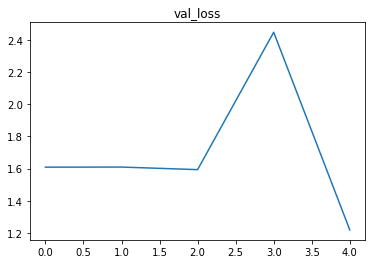

In [52]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(history.history['val_loss'])
plt.title('val_loss')

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/10 11:11:20


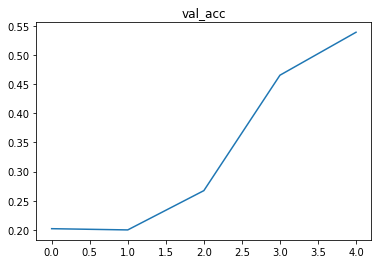

In [53]:
plt.plot(history.history['val_acc'])
plt.title('val_acc')

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

#### __学習済みモデルのpredict__

In [55]:
import cv2
from keras.models import load_model

from os import listdir
from os.path import isfile, join
import time


class predict_class:
    
    def __init__(self, model='multi_label.h5', test_image_path='test_image/'):
        """
        attribute
        ----------------
        model : model(.h5)
        test_image_path : テストファイルが入っているディレクトリ
        """
        self.model = load_model(model)
        self.test_image_path = test_image_path
    
    
    
    
    def predict(self, image, class_0='cocacola', class_1='fanta_litchi', class_2='lemon', class_3='namacha', class_4='soda_float'):
        """
        note : 与えられたimageのpathから、多値分類を行う関数
        ----------------
        attribute
        image : image画像のパス
        ----------------
        """
        class_name = [class_0, class_1, class_2, class_3, class_4]
        sample = load_img(image, target_size=(224,224))
        sample_arr = img_to_array(sample)
        sample_arr = np.expand_dims(sample_arr, axis=0)
        sample_arr = sample_arr /255
        result = self.model.predict(sample_arr)
        print('result prob : ', class_name[np.argmax(result)], '/ image : ', image)
        return class_name[np.argmax(result)]

        
    def accuracy_check(self):
        """
        note : test_imageディレクトリ内の複数のテストデータで、モデルの精度判定する関数
        ---------------
        """
        print('--------------------------------------------------------------------------------------')
        # 時間計測（start）
        start = time.time()

        # 画像ファイルの取り出し
        test_images = [f for f in listdir(self.test_image_path) if isfile(join(self.test_image_path, f))]
        test_images.remove('.DS_Store')

        collect = 0
        for test_image in test_images:
            class_name = self.predict(self.test_image_path + test_image)
            print('file name :', test_image, '/ class name :', class_name)
            if test_image[0] == class_name[0]:
                print('○')
                collect += 1
            else:
                print('×')
            print('--------------------------------------------------------------------------------------')


        print('正解数は{sample}サンプル中{collect}で、testデータの正解率は{rate}です。'.format(sample=len(test_images),
                                                                        collect=collect,
                                                                        rate=collect/len(test_images)))
        print('--------------------------------------------------------------------------------------')

        # 時間計測（end）
        elapsed_time = time.time() - start
        #print('合計秒数:：',elapsed_time)
        print('画像ごとの処理時間(秒) :', str((elapsed_time)/len(test_images)) )

    
    
    
if __name__ == '__main__':
    # インスタンスの作成
    predict = predict_class()
    
    # テストファイルのパスフォルダ名
    test_image_path = 'test_image/'

    predict.predict(test_image_path + 'aquarius__20190709160943.jpg')
    predict.accuracy_check()
    
    # どこまで実行しているか不明になるので...
    from datetime import datetime
    print('--------------------------------------------------------------------------------------')
    print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

result prob :  fanta_litchi / image :  test_image/aquarius__20190709160943.jpg
--------------------------------------------------------------------------------------
result prob :  soda_float / image :  test_image/coke_test_1.jpeg
file name : coke_test_1.jpeg / class name : soda_float
×
--------------------------------------------------------------------------------------
result prob :  fanta_litchi / image :  test_image/soda_float_test_2.jpg
file name : soda_float_test_2.jpg / class name : fanta_litchi
×
--------------------------------------------------------------------------------------
result prob :  fanta_litchi / image :  test_image/aquarius__20190709160943.jpg
file name : aquarius__20190709160943.jpg / class name : fanta_litchi
×
--------------------------------------------------------------------------------------
result prob :  soda_float / image :  test_image/soda_float_test_1.jpg
file name : soda_float_test_1.jpg / class name : soda_float
○
---------------------------------

#### __VGG16__

In [ ]:
from keras.applications.vgg16 import VGG16, decode_predictions

model_vgg16 = VGG16(include_top=True, weights='imagenet')
#model_vgg16.summary()

import cv2
from keras.models import load_model

def predict_class_vgg16(image):
    sample = load_img(image, target_size=(224,224))
    print(sample)
    sample_arr = img_to_array(sample)
    sample_arr = np.expand_dims(sample_arr, axis=0)
    result = model_vgg16.predict(sample_arr)
    print(decode_predictions(result, top=5))

In [ ]:
def predict_class(path_name):

    test_images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
    test_images.remove('.DS_Store')
    
    for test_image in test_images:
        print(test_image)
        predict_class_vgg16(test_image_path + test_image)
        print('--------------------------------------------------------------------------------------')

In [ ]:
predict_class(test_image_path)